In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from utils import *

# determine accuracy

In [3]:
# determine how many samples of each ancestry group
groupscsv = "../datasets/SraRunTableD1.txt"
goldstandard = "../datasets/1_gs.csv"
gs = pd.read_csv(goldstandard)
groups = pd.read_csv(groupscsv)

for group, df_by_group in groups.groupby('Population'):
    accession_numbers = df_by_group['Run'].values.tolist()
    gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
    print(len(gs_final))


95
114
111
103
67


In [4]:
data = list()
tools =["optitype","rna2hla","arcas","seq2hla","hlahd","phlat","hlaforest","hlavbseq",'hlaminer']

groupscsv = "../datasets/SraRunTableD1.txt"
groups = pd.read_csv(groupscsv)


for t in tools:
    toolresult = []
    
        
    gs=pd.read_csv("../datasets/1_gs.csv")
    pre=pd.read_csv("../results/standard/"+str(t)+"_d1.csv")

    for group, df_by_group in groups.groupby('Population'):
        accession_numbers = df_by_group['Run'].values.tolist()
        gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
        ret = compute_matches(pre,gs_final)
        ret = np.sum(np.array(ret),axis=1)
        #print(ret)
        toolresult.append(ret)


    europe = sum_euro_groups(toolresult[0:4])
    yoruba = toolresult[4]
    data.append([t, europe, yoruba])

    
    
df = pd.DataFrame(data,columns=['tool','europe','yoruba'])
print(df)

        tool             europe          yoruba
0   optitype     [10, 20, 2502]     [0, 8, 390]
1    rna2hla     [66, 90, 3196]   [13, 24, 481]
2      arcas    [35, 130, 3951]    [6, 67, 561]
3    seq2hla   [118, 230, 3844]   [27, 37, 584]
4      hlahd    [250, 92, 3864]   [28, 49, 555]
5      phlat   [173, 188, 3221]   [56, 58, 450]
6  hlaforest    [81, 447, 3476]   [41, 92, 451]
7   hlavbseq  [1856, 137, 2127]  [289, 26, 295]
8   hlaminer   [2911, 428, 291]   [503, 51, 34]


# chi square

In [4]:
# old method - chi square goodness of fit - incorrect method
pvalues = []
data = np.array(data)

for tool in data:
    etotal = sum(tool[1])
    ytotal = sum(tool[2])
    
    # 2 digit 
    e2dig_obs = tool[1][1]+tool[1][2]
    y2dig_obs = tool[2][1]+tool[2][2]
    e2dig_exp = (e2dig_obs+y2dig_obs)*etotal/(etotal+ytotal)
    y2dig_exp = (e2dig_obs+y2dig_obs)*ytotal/(etotal+ytotal)
    
    res2 = chisquare([e2dig_obs,y2dig_obs],[e2dig_exp,y2dig_exp])
    

    # 4 digit 
    e4dig_obs = tool[1][2]
    y4dig_obs = tool[2][2]
    e4dig_exp = (e4dig_obs+y4dig_obs)*etotal/(etotal+ytotal)
    y4dig_exp = (e4dig_obs+y4dig_obs)*ytotal/(etotal+ytotal)
    
    res4 = chisquare([e4dig_obs,y4dig_obs],[e4dig_exp,y4dig_exp])
    
    
    pvalues.append([res2.pvalue,res4.pvalue])

    print("\ntool: " ,tool[0] , "\n 2dig" , res2, "\n 4dig" , res4)



tool:  optitype 
 2dig Power_divergenceResult(statistic=0.005383150468523436, pvalue=0.9415117246436452) 
 4dig Power_divergenceResult(statistic=0.02372924384760334, pvalue=0.8775758362172591)

tool:  rna2hla 
 2dig Power_divergenceResult(statistic=0.01338932266849135, pvalue=0.9078806046760418) 
 4dig Power_divergenceResult(statistic=0.292524155416949, pvalue=0.5886075142741989)

tool:  arcas 
 2dig Power_divergenceResult(statistic=0.0005110563853369763, pvalue=0.9819641140366697) 
 4dig Power_divergenceResult(statistic=3.2579837652486883, pvalue=0.07107646947093756)

tool:  seq2hla 
 2dig Power_divergenceResult(statistic=0.10572397141672385, pvalue=0.7450658623050277) 
 4dig Power_divergenceResult(statistic=0.1521804553012401, pvalue=0.6964602853348794)

tool:  hlahd 
 2dig Power_divergenceResult(statistic=0.13353406071864726, pvalue=0.7147955813464589) 
 4dig Power_divergenceResult(statistic=0.9877936144202688, pvalue=0.3202822329500924)

tool:  phlat 
 2dig Power_divergenceResult(

/var/folders/j4/pd1pbcl90xz683wfkd2drjqw0000gn/T/ipykernel_62633/3150918999.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [17]:
# new method - chi square test of independence

data = np.array(data)
pvalues = []

for tool in data:
    etotal = sum(tool[1])
    ytotal = sum(tool[2])
    
    print(tool[0])
    
    # 2 digit 
    obs = [ [tool[1][1]+tool[1][2],tool[1][0]] , [tool[2][1]+tool[2][2],tool[2][0]] ]
    print("\t2 dig table:" , obs , "end")

    
    res = chi2_contingency(obs)
    print("\t2 dig p value:", res[1])
    # print([e2dig_obs, y2dig_obs])
    
    # 2 digit 
    e4dig_obs = [tool[1][2],tool[1][1]+tool[1][0]]
    y4dig_obs = [tool[2][2],tool[2][1]+tool[2][0]]

    
    res4 = chi2_contingency([e4dig_obs, y4dig_obs])
    print("\t4 dig table:" , [e4dig_obs, y4dig_obs] , "end")
    print("\t4 dig p value:", res4[1])
    
    pvalues.append([res[1],res4[1]])
    

    # print("\ntool: " ,tool[0] , "\n table", [e4dig_obs, y4dig_obs], "\n 4dig" , res4.pvalue)


optitype
	2 dig table: [[2522, 10], [398, 0]] end
	2 dig p value: 0.4274226627380222
	4 dig table: [[2502, 30], [390, 8]] end
	4 dig p value: 0.26512704988009617
rna2hla
	2 dig table: [[3286, 66], [505, 13]] end
	2 dig p value: 0.520254545608651
	4 dig table: [[3196, 156], [481, 37]] end
	4 dig p value: 0.020696968768916475
arcas
	2 dig table: [[4081, 35], [628, 6]] end
	2 dig p value: 0.9898513595701539
	4 dig table: [[3951, 165], [561, 73]] end
	4 dig p value: 1.6403938880641863e-15
seq2hla
	2 dig table: [[4074, 118], [621, 27]] end
	2 dig p value: 0.07930096596106705
	4 dig table: [[3844, 348], [584, 64]] end
	4 dig p value: 0.20715065100799598
hlahd
	2 dig table: [[3956, 250], [604, 28]] end
	2 dig p value: 0.15192395968585204
	4 dig table: [[3864, 342], [555, 77]] end
	4 dig p value: 0.0009621184326222613
phlat
	2 dig table: [[3409, 173], [508, 56]] end
	2 dig p value: 1.375733182744218e-06
	4 dig table: [[3221, 361], [450, 114]] end
	4 dig p value: 3.578955859505009e-12
hlaforest

# plotting

In [18]:
# calculating accuracy, creating data frames
europe = np.array( df['europe'].values.tolist() )
total = np.sum(europe,axis=1)
europe_4dig = (europe[:,2])/total
europe_2dig = (europe[:,1]+europe[:,2])/total

yoruba = np.array( df['yoruba'].values.tolist() )
total = np.sum(yoruba,axis=1)
yoruba_4dig = (yoruba[:,2])/total
yoruba_2dig = (yoruba[:,1]+yoruba[:,2])/total

# concat to df
dfeuro2dig = pd.DataFrame(europe_2dig,columns=['europe two dig accuracy'])
dfeuro4dig = pd.DataFrame(europe_4dig,columns=['europe four dig accuracy'])
dfyoru2dig = pd.DataFrame(yoruba_2dig,columns=['yoruba two dig accuracy'])
dfyoru4dig = pd.DataFrame(yoruba_4dig,columns=['yoruba four dig accuracy'])

         tool                  ancestry  accuracy
0    optitype  europe four dig accuracy  0.988152
1     rna2hla  europe four dig accuracy  0.953461
2       arcas  europe four dig accuracy  0.959913
3     seq2hla  europe four dig accuracy  0.916985
4       hlahd  europe four dig accuracy  0.918688
5       phlat  europe four dig accuracy  0.899218
6   hlaforest  europe four dig accuracy  0.868132
7    hlavbseq  europe four dig accuracy  0.516262
8    hlaminer  europe four dig accuracy  0.080165
9    optitype  yoruba four dig accuracy  0.979899
10    rna2hla  yoruba four dig accuracy  0.928571
11      arcas  yoruba four dig accuracy  0.884858
12    seq2hla  yoruba four dig accuracy  0.901235
13      hlahd  yoruba four dig accuracy  0.878165
14      phlat  yoruba four dig accuracy  0.797872
15  hlaforest  yoruba four dig accuracy  0.772260
16   hlavbseq  yoruba four dig accuracy  0.483607
17   hlaminer  yoruba four dig accuracy  0.057823


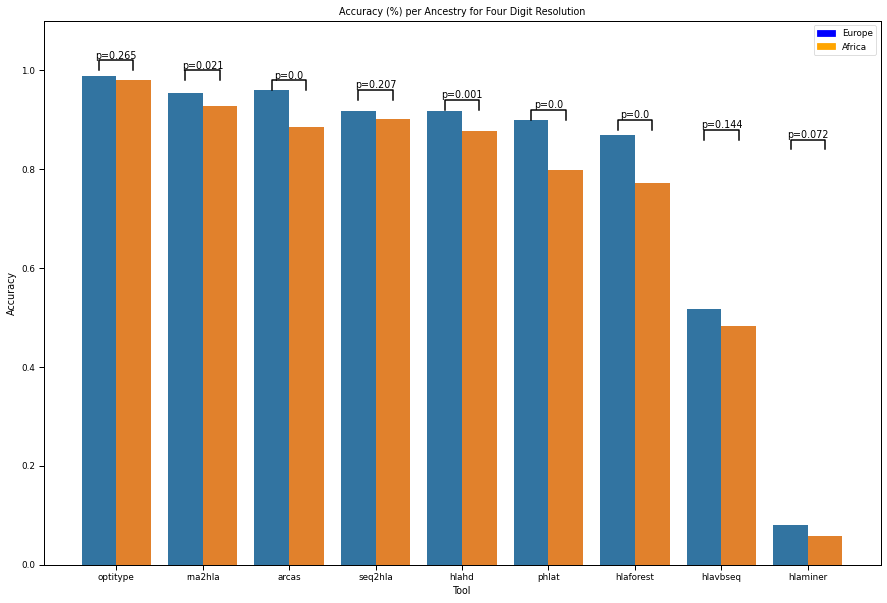

In [19]:
# 4 dig accuracy

df_accuracy=pd.concat([df['tool'],dfeuro4dig,dfyoru4dig],axis=1, join='inner')

df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)


sns.set_context("paper")
sns.color_palette("pastel")
plt.figure(figsize=(15,10))



ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=tools)

for i in range(9):
    x1, x2 = -0.2+i, 0.2+i 
    y, h, col = 1-i*0.02, 0.02, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f"p={round(pvalues[i][1],3)}", ha='center', va='bottom', color=col)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Tool")
ax.set_title("Accuracy (%) per Ancestry for Four Digit Resolution") 
plt.legend(labels=['Yoruba','Europe'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1.1))
#sns.despine()

colors = {'Europe':'blue', 'Africa':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)


plt.show()

#plt.savefig('../Figures/read_length_accuracy_4dig.png',bbox_inches ="tight",dpi=300)

         tool                 ancestry  accuracy
0    optitype  europe two dig accuracy  0.996051
1     rna2hla  europe two dig accuracy  0.980310
2       arcas  europe two dig accuracy  0.991497
3     seq2hla  europe two dig accuracy  0.971851
4       hlahd  europe two dig accuracy  0.940561
5       phlat  europe two dig accuracy  0.951703
6   hlaforest  europe two dig accuracy  0.979770
7    hlavbseq  europe two dig accuracy  0.549515
8    hlaminer  europe two dig accuracy  0.198072
9    optitype  yoruba two dig accuracy  1.000000
10    rna2hla  yoruba two dig accuracy  0.974903
11      arcas  yoruba two dig accuracy  0.990536
12    seq2hla  yoruba two dig accuracy  0.958333
13      hlahd  yoruba two dig accuracy  0.955696
14      phlat  yoruba two dig accuracy  0.900709
15  hlaforest  yoruba two dig accuracy  0.929795
16   hlavbseq  yoruba two dig accuracy  0.526230
17   hlaminer  yoruba two dig accuracy  0.144558


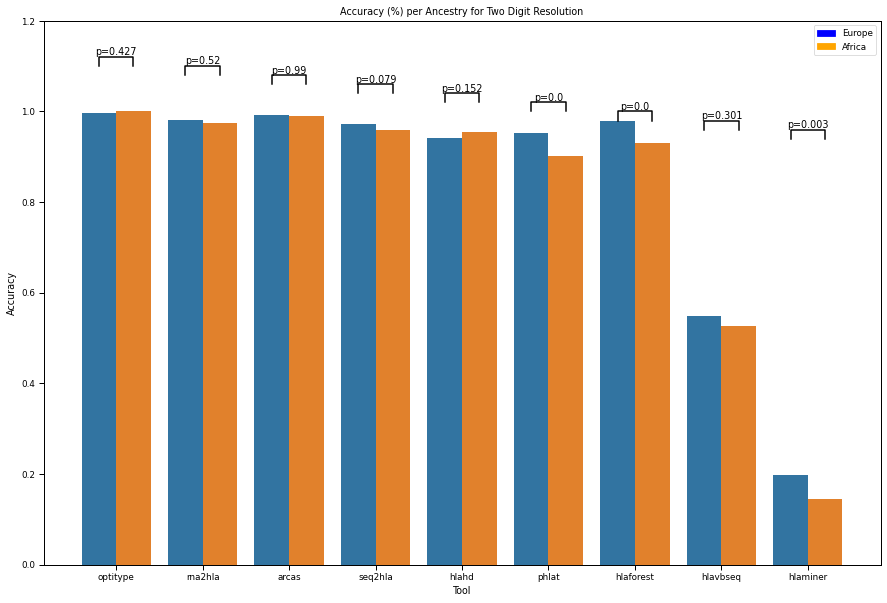

In [20]:
# 2 dig accuracy plot
df_accuracy=pd.concat([df['tool'],dfeuro2dig,dfyoru2dig],axis=1, join='inner')
df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)


sns.set_context("paper")
sns.color_palette("pastel")
plt.figure(figsize=(15,10))



ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=tools)


for i in range(9):
    x1, x2 = -0.2+i, 0.2+i 
    y, h, col = 1.1-i*0.02, 0.02, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f"p={round(pvalues[i][0],3)}", ha='center', va='bottom', color=col)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Tool")
ax.set_title("Accuracy (%) per Ancestry for Two Digit Resolution") 
plt.legend(labels=['Yoruba','Europe'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1.2))
#sns.despine()

colors = {'Europe':'blue', 'Africa':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

#plt.savefig('../Figures/read_length_accuracy_4dig.png',bbox_inches ="tight",dpi=300)

In [8]:
# getting 